# ML in Cybersecurity: IAM Project

1. Role Mining: This is your core solution. Find reasonable ways of bundling
entitlements into single roles so that managers only have to attest to one
line item. Don’t worry about describing those roles, IAM can do that.
Your concern is to convince the business that your method is sound.
2. Default entitlements: Right now, none of these entitlements are given to
employees by default. Removing them entirely from the attestation might
help. You may or may not be able to do this. It depends on the data.
Report your findings.
In addition, you need to perform some quality control. This involves a few
methods:
1. Identify toxic combinations. It is important that they not be bundled into
a role, and that users with existing toxic combinations are flagged.
2. identify anomalous data. This can be users, entitlements, or user-entitlement
pairs. There may or may not be anomalies right now, but in any case it
is good to have an approach to deploy should the occasion arise.
3. Identify and score poorly described entitlements. Return scores at an
application level. This allows us to return to the application owner and ask
them to improve their documentation. (Don’t worry if all the applications
have similar scores - I didn’t consider that when generating this data,
oops!)

## Phase 1: Data Load + Cleaning

### Import Libraries and Load Files
Importing libraries that will be used for the project.

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import re
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from textstat import flesch_reading_ease

import seaborn as sns
import matplotlib.pyplot as plt




In [3]:
# Load data
df_dic = {}

data_dir = "../csv_files"
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    df_dic[filename] = pd.read_csv(file_path)


In [4]:
# Make a copy of the dataframes
assignments = df_dic['assignments.csv'].copy()
entitlements = df_dic['entitlements.csv'].copy()
applications = df_dic['applications.csv'].copy()
employees = df_dic['employees.csv'].copy()
departments = df_dic['departments.csv'].copy()

In [5]:
print(assignments.columns)
print(entitlements.columns)
print(applications.columns)
print(employees.columns)
print(departments.columns)

Index(['employee_id', 'entitlement_id', 'grant_date'], dtype='object')
Index(['entitlement_id', 'name', 'application_id', 'type', 'description',
       'risk_level'],
      dtype='object')
Index(['application_id', 'name', 'description', 'criticality'], dtype='object')
Index(['employee_id', 'name', 'department_id', 'job_title', 'hire_date',
       'manager_id'],
      dtype='object')
Index(['department_id', 'name', 'parent_id'], dtype='object')


## Basic Sanity Checks

In [6]:
# Quick look at the data
for name, df in {
    "Applications": applications,
    "Entitlements": entitlements,
    "Employees": employees,
    "Assignments": assignments,
    "Departments": departments,
}.items():
    print(f"\n###### {name} #####")
    print(df.shape)
    print("-------------------------")
    print(df.head(3))
    print("-------------------------")
    print(df.dtypes)
    print("-------------------------")
    print(df.isnull().sum())
    print("\n")



###### Applications #####
(50, 4)
-------------------------
  application_id         name                                   description  \
0           A001  CoreBanking  Core banking platform for account management   
1           A002   PaymentHub  Payment processing and reconciliation system   
2           A003  CustomerCRM     Customer relationship management platform   

   criticality  
0            9  
1            8  
2            6  
-------------------------
application_id    object
name              object
description       object
criticality        int64
dtype: object
-------------------------
application_id    0
name              0
description       0
criticality       0
dtype: int64



###### Entitlements #####
(2000, 6)
-------------------------
  entitlement_id                      name application_id   type  \
0         ENT001    Admin_Customeraccounts           A001  admin   
1         ENT002      Read_Accountsettings           A001   read   
2         ENT003  Admin_Tr

### Key Relationships (Making sure key relations are in the right place.)

#### Check foreign key relationships
1. Do all entitlement_ids in assignments exist in entitlements?
2. Do all employee_ids in assignments exist in employees?
3. Do all application_ids in entitlements exist in applications?
4. Do all departments exist in department file?

The questions above will help to sanitize the database of the bank.

In [7]:
# Check foreign key relationships
# 1. Do all entitlement_ids in assignments exist in entitlements?
missing_ent_ids = set(assignments['entitlement_id']) - set(entitlements['entitlement_id'])
print(
    f"{'All entitlement_ids in assignments exist in entitlements' if len(missing_ent_ids) == 0 else f'This(These) entitlement_ids, {missing_ent_ids}, in assignments are not in entitlements.'}"
)


# 2. Do all employee_ids in assignments exist in employees?
missing_emp_ids = set(assignments['employee_id']) - set(employees['employee_id'])
#print("Missing employee_ids:", missing_emp_ids)
print(
    f"{'All employee_ids in assignments exist in employees' if len(missing_emp_ids) == 0 else f'This(These) employee_ids, {missing_emp_ids}, in assignments are not in employees.'}"
)

# 3. Do all application_ids in entitlements exist in applications?
missing_app_ids = set(entitlements['application_id']) - set(applications['application_id'])
#print("Missing application_ids:", missing_app_ids)
print(
    f"{'All application_ids in entitlements exist in applications' if len(missing_app_ids) == 0 else f'This(These) application_ids, {missing_app_ids}, in entitlements are not in applications.'}"
)

# 4. Do all departments exist in department file?
missing_dept_ids = set(employees['department_id']) - set(departments['department_id'])
#print("Missing department_ids:", missing_dept_ids)
print(
    f"{'All department_ids in employees exist in departments' if len(missing_dept_ids) == 0 else f'This(These) department_ids, {missing_app_ids}, in employees are not in departments.'}"
)


All entitlement_ids in assignments exist in entitlements
All employee_ids in assignments exist in employees
All application_ids in entitlements exist in applications
All department_ids in employees exist in departments


In [8]:
# Rename description and name columns
entitlements = entitlements.rename(columns={'description': 'entitlement_description', 'name':'entitlement_name'})
applications = applications.rename(columns={'description': 'application_description', 'name':'application_name'})
employees = employees.rename(columns={'name':'employee_name'})
departments = departments.rename(columns={'name':'department_name'})

# Merge assignments with entitlement, application and employees info
temp_merged = assignments.merge(entitlements, on="entitlement_id", how="left")
temp_merged = temp_merged.merge(applications, on="application_id", how="left")
temp_merged = temp_merged.merge(employees, on="employee_id", how="left")
assign_ent_emp_dept = temp_merged.copy()

## Combine all dataframes

In [9]:
df = assignments.merge(entitlements, on='entitlement_id', how='left')
df = df.merge(applications, on='application_id', how='left')
df = df.merge(employees, on='employee_id', how='left')
df = df.merge(departments, on='department_id', how='left')
combined_dfs = df.copy()


# Phase 2: Reducing Line Items



###  Role Mining
- `Todo:` Role Mining: This is your core solution. Find reasonable ways of bundling
entitlements into single roles so that managers only have to attest to one
line item. Don’t worry about describing those roles, IAM can do that.
Your concern is to convince the business that your method is sound.

- `Goal:` The goal of this is to group entitlements into meaningful roles so that managers can attest to a role instead of dozens of individual entitlements.

### Build Employee-Entitlement Matrix and Cluster Employess Based on Entitlements

##  Real-Life Example Roles in a Bank

| Role Name              | Typical Entitlements                              |
| ---------------------- | ------------------------------------------------- |
| **Branch Teller**      | Cash app access, Account lookup, Transaction post |
| **Loan Officer**       | Credit systems, Underwriting tools                |
| **Trader**             | Bloomberg terminal, Trade booking, Market data    |
| **Compliance Analyst** | Case mgmt, Audit trail access, (Anti-Money Laundering )AML reports        |
| **Finance IT Admin**   | Systems, Applications, and Products(SAP) Admin, User provisioning, Logging             |


In [10]:
role_mining_df = combined_dfs[[
    'employee_id',
    'entitlement_id',
    'entitlement_name',
    'type',
    'risk_level',
    'application_name',     
    'criticality',
    'job_title',
    'department_name'  
]]


# Another Binarizer (Request from Chris)
So I put the binarizer for the departments in a dictionary

In [48]:
dept_df = combined_dfs.copy() # A copy of all the combined dataframes

grouped_depts = dept_df.groupby(['department_id', 'department_name'])
department_dfs = {f"dept_{dept_id}_{dept_name}": group.copy() for (dept_id, dept_name), group in grouped_depts}

#department_dfs['dept_D002_Finance']

# Dictionaries to hold the results
binarizers_per_dept = {}       # Stores MultiLabelBinarizer per department
binarizers_per_dept_dfs = {}    # Stores binarized DataFrame per department

for dept_key, dept_df in department_dfs.items():
    ## Group by employee_id and Map each employee to a set of entitlements
    entitlements_sets = dept_df.groupby(['employee_id', 'employee_name'])['entitlement_id'].apply(set)
    
    # Reset index to get both employee_id and employee_name as columns
    entitlements_sets = entitlements_sets.reset_index()
    #print(entitlements_sets)

    # Initialize and fit the binarizer on the 'entitlements' column
    mlb = MultiLabelBinarizer()
    entitlements_binarized = mlb.fit_transform(entitlements_sets['entitlement_id'])

    # Create binarized DataFrame
    binarized_df = pd.DataFrame(
        entitlements_binarized,
        columns=mlb.classes_,
    )

    # Insert Employee_ID and Employee columns at the front
    binarized_df.insert(0, 'employee_name', entitlements_sets['employee_name'].values)
    binarized_df.insert(0, 'employee_id', entitlements_sets['employee_id'].values)

    # Store the results
    binarizers_per_dept[dept_key] = mlb
    binarizers_per_dept_dfs[dept_key] = binarized_df


## Example for the treasury department

In [47]:
binarizers_per_dept_dfs['dept_D011_Treasury']

,employee_id,employee_name,ENT001,ENT002,ENT003,ENT004,ENT005,ENT006,ENT007,ENT008,...,ENT990,ENT991,ENT992,ENT993,ENT994,ENT995,ENT996,ENT997,ENT998,ENT999
0,E001,Alonzo Postley,0,1,0,1,1,1,1,1,...,1,0,0,0,0,0,1,0,1,0
1,E007,Elida Palmer,0,1,0,1,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1
2,E014,Irving Martin,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,E015,Guadalupe Kremer,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,E018,Betty Jordan,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,E972,Catherine Capizzi,0,1,0,0,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
77,E974,Kathryn Andre,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
78,E988,Douglas Dragich,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
79,E989,Henry Hamilton,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Using MultiLabelBinarizer

In [11]:

# Map each employee to a set of entitlements
user_ent_map = assignments.groupby('employee_id')['entitlement_id'].apply(set)

# Transform into binary matrix
mlb = MultiLabelBinarizer()
emp_ent_matrix = mlb.fit_transform(user_ent_map)
entitlement_labels = mlb.classes_
user_ids = user_ent_map.index

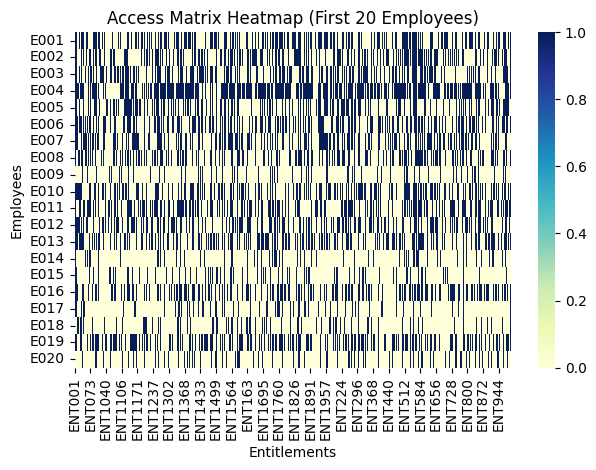

In [12]:
access_matrix_df = pd.DataFrame(
    emp_ent_matrix,
    index=user_ids,              # list of employee IDs in the same order
    columns=entitlement_labels             # entitlement or access labels
)

sns.heatmap(access_matrix_df.head(20), cmap="YlGnBu", cbar=True)
plt.title("Access Matrix Heatmap (First 20 Employees)")
plt.xlabel("Entitlements")
plt.ylabel("Employees")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Using Elbow Method and Silhoutte Score for KMeans Clustering

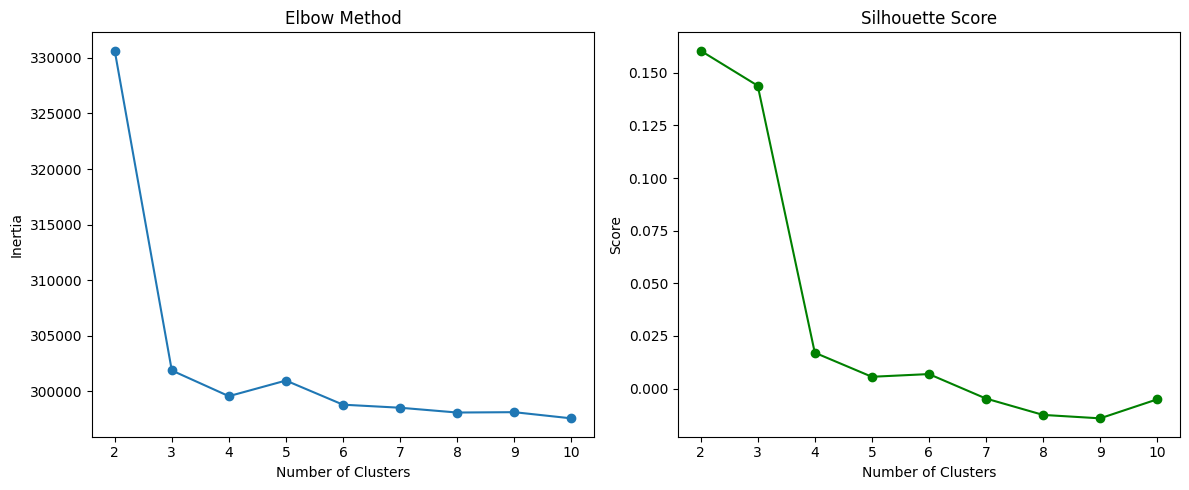

In [13]:
# Assuming access_matrix is already defined and role column exists
X = emp_ent_matrix

# Choose range of k values
k_values = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot Elbow and Silhouette side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Elbow Plot
axs[0].plot(k_values, inertias, marker='o')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Inertia')

# Silhouette Plot
axs[1].plot(k_values, silhouette_scores, marker='o', color='green')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Score')

plt.tight_layout()
plt.show()


### Visualize the cluster (Kmeans)

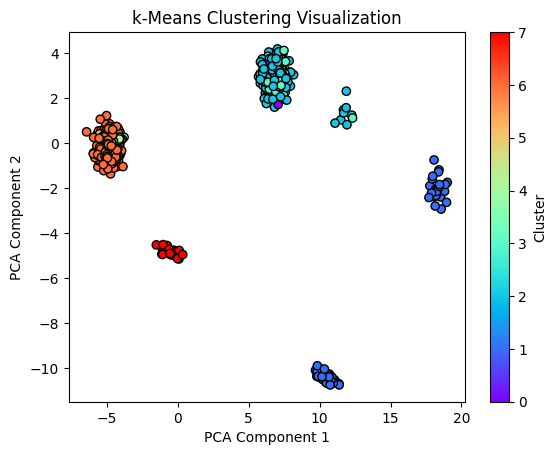

In [14]:
# Using kMeans
# Try different values for k (e.g. 5–15)
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(emp_ent_matrix)
#print(labels)

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(emp_ent_matrix)

plt.scatter(reduced_data[:,0], reduced_data[:,1], c = labels, cmap='rainbow', edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("k-Means Clustering Visualization")
plt.colorbar(label="Cluster")
plt.show()

## Extract Entitlement Bundles (Roles)

In [15]:

# For each cluster, find most common entitlements
roles = []
for i in range(k):
    cluster_members = emp_ent_matrix[labels == i]
    #print(cluster_members)
    freq = np.mean(cluster_members, axis=0)
    #print(freq)
    role_ents = [entitlement_labels[j] for j, val in enumerate(freq) if val > 0.5]  # tune threshold
    roles.append({
        "role_id": f"Role_{i+1}",
        "entitlements": role_ents,
        "num_users": cluster_members.shape[0]
    })


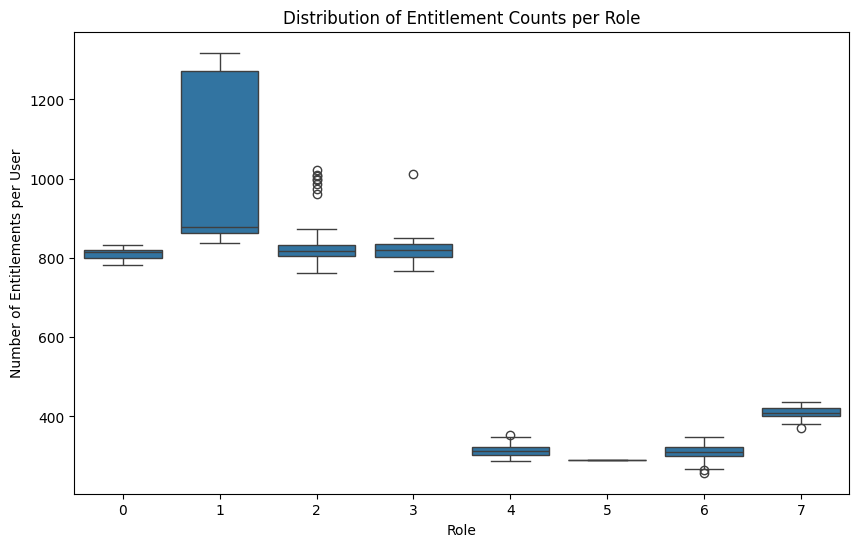

In [16]:
access_matrix_with_roles = access_matrix_df.copy()
access_matrix_with_roles['role'] = labels

# Sum of entitlements per user
user_entitlement_counts = access_matrix_with_roles.drop(columns='role').sum(axis=1)

# Merge with role labels
role_entitlement_dist = pd.DataFrame({
    'role': labels,
    'entitlement_count': user_entitlement_counts
})

# Plot distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='role', y='entitlement_count', data=role_entitlement_dist)
plt.title("Distribution of Entitlement Counts per Role")
plt.xlabel("Role")
plt.ylabel("Number of Entitlements per User")
plt.show()

In [17]:
role_entitlement_dist

,role,entitlement_count
employee_id,,
E001,3,805
E002,2,803
E003,2,854
E004,1,1276
E005,2,799
...,...,...
E995,6,314
E996,6,323
E997,2,777


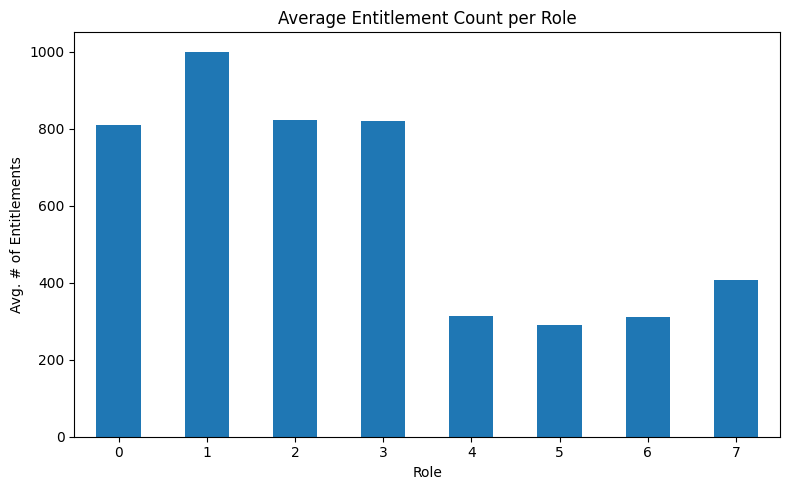

In [18]:
role_avg = role_entitlement_dist.groupby('role')['entitlement_count'].mean()

role_avg.plot(kind='bar', figsize=(8, 5), title="Average Entitlement Count per Role")
plt.ylabel("Avg. # of Entitlements")
plt.xlabel("Role")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Map Users to Roles & Estimate Attestation Reduction

This shows how much attestation can be reduced considerably.

In [19]:
user_roles = pd.DataFrame({
    "employee_id": user_ids,
    "role_id": [f"Role_{i+1}" for i in labels]
})

original_line_items = assignments.shape[0]
new_line_items = user_roles.shape[0]

print(f"Original attestation line items: {original_line_items}")
print(f"Reduced (role-based) attestation line items: {new_line_items}")
print(f"Reduction: {100 * (1 - new_line_items / original_line_items):.2f}%")


Original attestation line items: 512716
Reduced (role-based) attestation line items: 1000
Reduction: 99.80%


## Identify Default Entitlements per Group


In [20]:
def detect_defaults(assignments_df, group_col, threshold=0.95):
    results = []
    for group, df_group in assignments_df.groupby(group_col):
        total_users = df_group['employee_id'].nunique()
        freq_table = df_group.groupby('entitlement_id')['employee_id'].nunique() / total_users
        default_entitlements = freq_table[freq_table >= threshold].index.tolist()
        if default_entitlements:
            results.append({
                "group_type": group_col,
                "group_value": group,
                "default_entitlements": default_entitlements
            })
    return results

#Merge Assignments with Employee
assignments_emp_merged = assignments.merge(employees, on='employee_id')

default_by_job = detect_defaults(assignments_emp_merged, 'job_title')
default_by_dept = detect_defaults(assignments_emp_merged, 'department_id')


## Some visuals for role mining

### Attestation Line Item Reduction

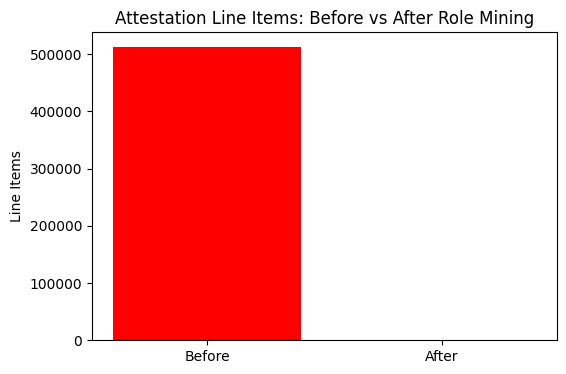

In [21]:

# Simple comparison of total attestation items before and after
plt.figure(figsize=(6,4))
plt.bar(['Before', 'After'], [original_line_items, new_line_items], color=['red', 'green'])
plt.title('Attestation Line Items: Before vs After Role Mining')
plt.ylabel('Line Items')
plt.show()


## Role Size Distribution

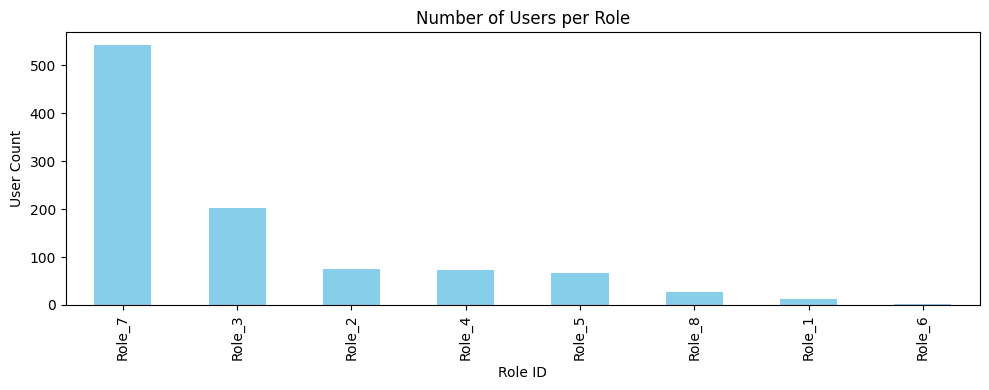

In [22]:
role_sizes = pd.Series([r['num_users'] for r in roles], index=[r['role_id'] for r in roles])

role_sizes.sort_values(ascending=False).plot(kind='bar', figsize=(10,4), color='skyblue')
plt.title("Number of Users per Role")
plt.xlabel("Role ID")
plt.ylabel("User Count")
plt.tight_layout()
plt.show()


## Default Entitlements by Group

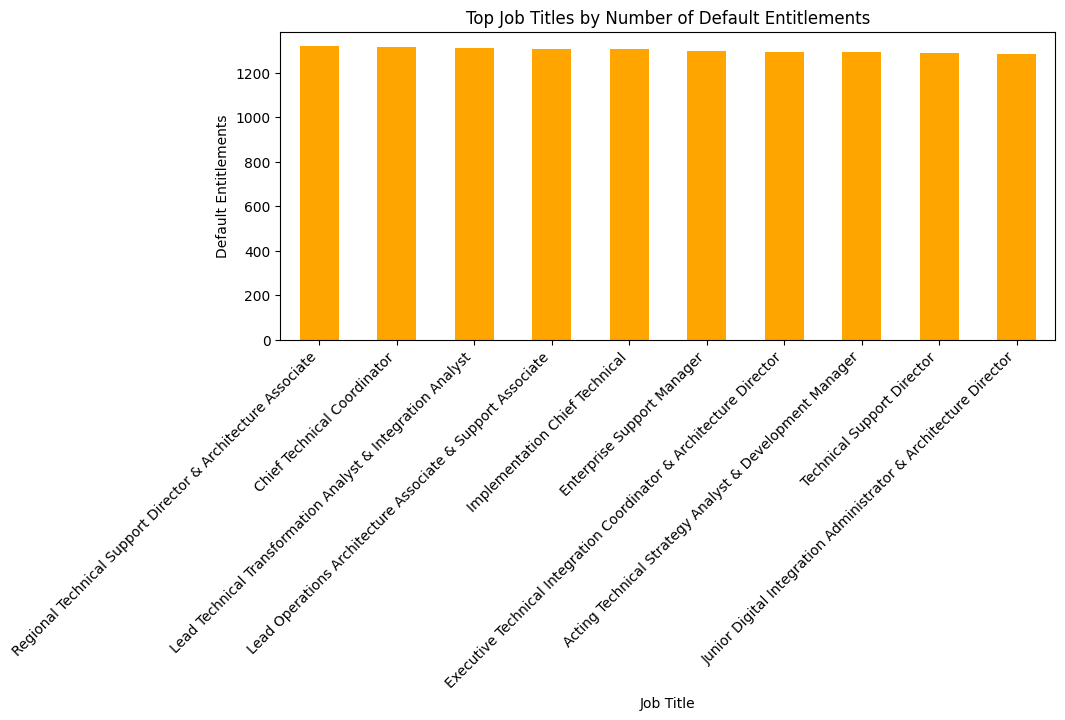

In [23]:
# Convert to DataFrame for job title
default_job_df = pd.DataFrame(default_by_job)
default_job_df['count'] = default_job_df['default_entitlements'].apply(len)

default_job_df[['group_value', 'count']].sort_values(by='count', ascending=False).head(10).plot(
    kind='bar', x='group_value', y='count', figsize=(10, 4), legend=False, color='orange')
plt.title('Top Job Titles by Number of Default Entitlements')
plt.ylabel('Default Entitlements')
plt.xlabel('Job Title')
plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()


## Phase 3: Improve Data Quality
- Detect Toxic Entitlement Combinations
- Identify Anomalous Users
- Score Poorly Described Entitlements

# Toxic Combinations (Fraud & Cybersecurity Risk)

**Goal:**
Flag users (or roles) that have dangerous combinations of entitlements — either due to fraud risk (maker-checker violations) or cybersecurity risk (admin + operational overlap in the same app).



# Preprocessing
1. Extract keywords from entitlement descriptions to classify them as:

    - Maker (e.g., create, input) vs Checker (e.g., approve, authorize)

    - Admin (e.g., configure, control) vs Operational (e.g., read, modify)

2. Group by application to ensure both entitlements come from the same app.



### Classify Entitlements Using type and description

In [24]:
# Define keyword lists
maker_keywords = ['create', 'initiate', 'input', 'submit', 'enter']
checker_keywords = ['approve', 'authorize', 'release', 'confirm']
admin_keywords = ['administer', 'configure', 'manage', 'control']
operational_keywords = ['read', 'monitor', 'modify', 'access', 'update', 'delete']

# Compile regex patterns
def compile_pattern(keywords):
    return re.compile(r'\b(?:' + '|'.join(map(re.escape, keywords)) + r')\b')

maker_pattern = compile_pattern(maker_keywords)
checker_pattern = compile_pattern(checker_keywords)
admin_pattern = compile_pattern(admin_keywords)
operational_pattern = compile_pattern(operational_keywords)

# Updated classification function using both type and description
def classify_entitlement(row):
    ent_type = set()

    # Use the 'type' column if available
    raw_type = row.get('type', '')
    if isinstance(raw_type, str):
        t = raw_type.lower()
        if t == 'admin':
            ent_type.add('admin')
        elif t in {'read', 'write', 'execute'}:
            ent_type.add('operational')

    # Use 'description' column (fallback or to capture maker/checker)
    desc = row.get('entitlement_description', '')
    if isinstance(desc, str):
        desc = desc.lower()
        if maker_pattern.search(desc):
            ent_type.add('maker')
        if checker_pattern.search(desc):
            ent_type.add('checker')
        if admin_pattern.search(desc):
            ent_type.add('admin')
        if operational_pattern.search(desc):
            ent_type.add('operational')

    return ent_type


# Add classification column to entitlements
entitlements['toxic_tags'] = entitlements.apply(classify_entitlement, axis=1)


In [25]:
entitlements['toxic_tags']

0       {admin, operational}
1              {operational}
2                    {admin}
3              {operational}
4              {operational}
                ...         
1995           {operational}
1996           {operational}
1997    {admin, operational}
1998           {operational}
1999    {admin, operational}
Name: toxic_tags, Length: 2000, dtype: object

## Detect Toxic Combinations by User (Same App, High Risk)

In [26]:
# Merge assignments with entitlements
assignments_merged = assignments.merge(entitlements, on='entitlement_id')

# Group by employee and application
toxic_users = []

for (employee, app), group in assignments_merged.groupby(['employee_id', 'application_id']):
    types = set.union(*grou p['toxic_tags'])
    if 'maker' in types and 'checker' in types:
        toxic_users.append((employee, app, 'fraud'))
    if 'admin' in types and 'operational' in types:
        toxic_users.append((employee, app, 'cyber'))

# View toxic access cases
toxic_df = pd.DataFrame(toxic_users, columns=['employee_id', 'application_id', 'risk_type'])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2941716704.py, line 8)

In [ ]:
assignments_with_ent = assignments.merge(entitlements, on='entitlement_id')
user_groups = assignments_with_ent.groupby('employee_id')

# Group by employee and application
toxic_users = []
for user, group in user_groups:
    ent_map = group.groupby('application_id')['toxic_tags'].apply(lambda tags: set.union(*tags))
    for app_id, tags in ent_map.items():
        if 'maker' in tags and 'checker' in tags:
            risk_sum = group[group['application_id'] == app_id]['risk_level'].sum()
            toxic_users.append((user, app_id, 'maker+checker', risk_sum))
        if 'admin' in tags and 'operational' in tags:
            risk_sum = group[group['application_id'] == app_id]['risk_level'].sum()
            toxic_users.append((user, app_id, 'admin+operational', risk_sum))


## Anomaly Detection

Treat each user as a vector of entitlements (just like in role mining), then use unsupervised anomaly detection to flag outliers.

In [ ]:

# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomaly_scores = iso_forest.fit_predict(emp_ent_matrix)  # -1 = anomaly, 1 = normal

# Collect anomalous users
anomalies = [user_ids[i] for i, p in enumerate(anomaly_scores) if p == -1]
anomalous_users = pd.DataFrame({'employee_id': anomalies})


In [ ]:
# Merge with employee details
anomalous_users_full = anomalous_users.merge(employees, on='employee_id', how='left')

print(anomalous_users_full[['employee_id', 'employee_name', 'job_title', 'department_id']].head())


  employee_id       employee_name                        job_title  \
0        E004      David Tennyson         Chief Technical Director   
1        E007        Elida Palmer          Senior Customer Manager   
2        E019          Jill Edens  Business Transformation Manager   
3        E022  Christopher Cooper      Executive Customer Director   
4        E023       Marcelo Bondy      Principal Financial Manager   

  department_id  
0          D008  
1          D011  
2          D004  
3          D002  
4          D009  


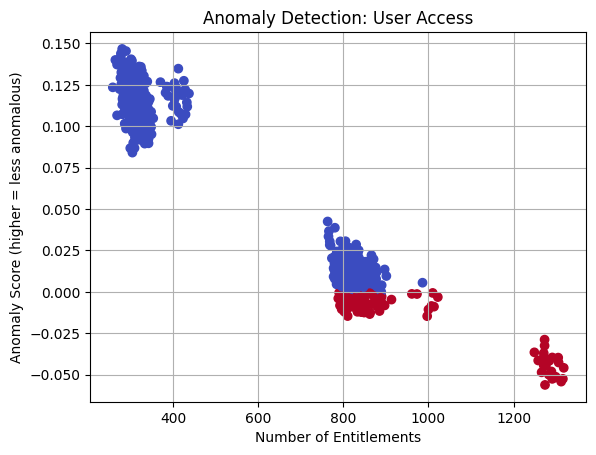

In [ ]:
# You can visualize which users are flagged by their number of entitlements
ent_count = emp_ent_matrix.sum(axis=1)
plt.scatter(ent_count, iso_forest.decision_function(emp_ent_matrix), c=(anomaly_scores == -1), cmap='coolwarm')
plt.xlabel("Number of Entitlements")
plt.ylabel("Anomaly Score (higher = less anomalous)")
plt.title("Anomaly Detection: User Access")
plt.grid(True)
plt.show()


## Entitlement Description Quality

In [ ]:

# Drop rows with missing descriptions from entitlements
ent_des_dropna = entitlements.dropna(subset=['entitlement_description'])
entitlements_drop = ent_des_dropna.copy()

entitlements_drop['desc_len'] = entitlements_drop['entitlement_description'].astype(str).str.len()
entitlements_drop['flesch'] = entitlements['entitlement_description'].astype(str).apply(flesch_reading_ease)
entitlements_drop['vocab_richness'] = entitlements_drop['entitlement_description'].astype(str).apply(lambda x: len(set(x.split())) / (len(x.split()) + 1e-5))

quality_scores = entitlements_drop.groupby('application_id')[['desc_len', 'flesch', 'vocab_richness']].mean().reset_index()


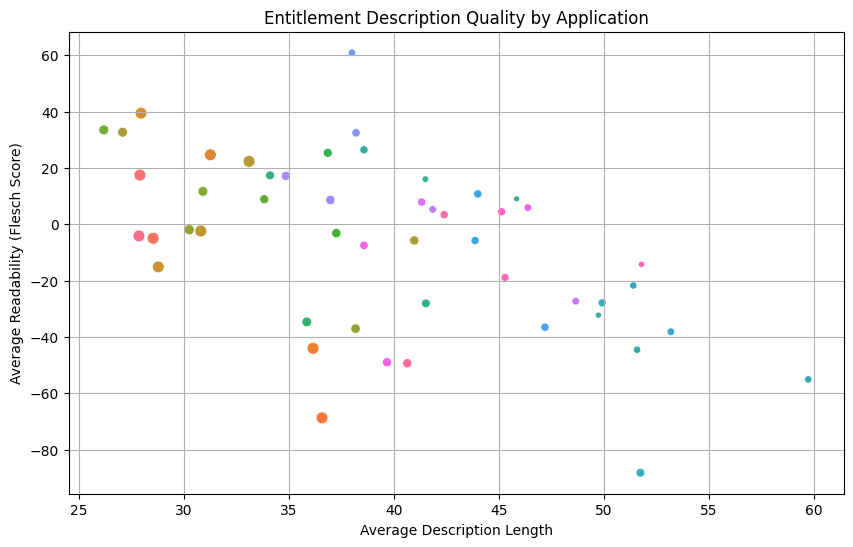

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=quality_scores,
    x ='desc_len',
    y ='flesch',
    size='vocab_richness',
    hue='application_id',
    legend=False
)
plt.title("Entitlement Description Quality by Application")
plt.xlabel("Average Description Length")
plt.ylabel("Average Readability (Flesch Score)")
plt.grid(True)
plt.show()


In [ ]:
def has_toxic_combo(ent_ids, ent_df):
    ent_df_subset = ent_df[ent_df['entitlement_id'].isin(ent_ids)]
    for app_id, group in ent_df_subset.groupby('application_id'):
        types = set().union(*group['toxic_tags'])
        if 'maker' in types and 'checker' in types:
            return True
        if 'admin' in types and 'operational' in types:
            return True
    return False

# Clean roles
clean_roles = []
non_clean_roles = []
for role in roles:
    if not has_toxic_combo(role['entitlements'], entitlements):
        clean_roles.append(role)
    else:
        non_clean_roles.append(role)


## Access Duration Analysis

 Identify users who have had access to entitlements for unusually long durations, especially those linked to high-risk permissions. This can help surface stale, forgotten, or policy-violating access.

 ### Calculate Duration of Access

In [ ]:
assignments_with_dates = assignments.merge(entitlements, on='entitlement_id')

# Ensure grant_date is in datetime format
assignments_with_dates['grant_date'] = pd.to_datetime(assignments_with_dates['grant_date'])

# Calculate duration in days and years
assignments_with_dates['access_duration_days'] = (pd.Timestamp.now() - assignments_with_dates['grant_date']).dt.days
assignments_with_dates['access_duration_years'] = assignments_with_dates['access_duration_days']/365


### Flag long High-Risk Access

In [ ]:
# Define thresholds
high_risk_threshold = 8  # years : We can change this value.
duration_threshold = 3
# Flag long-duration high-risk entitlements
long_risky_access = assignments_with_dates[
    (assignments_with_dates['access_duration_years'] > duration_threshold) &
    (assignments_with_dates['risk_level'] >= high_risk_threshold)
]

### Visualize Access Duration Distribution

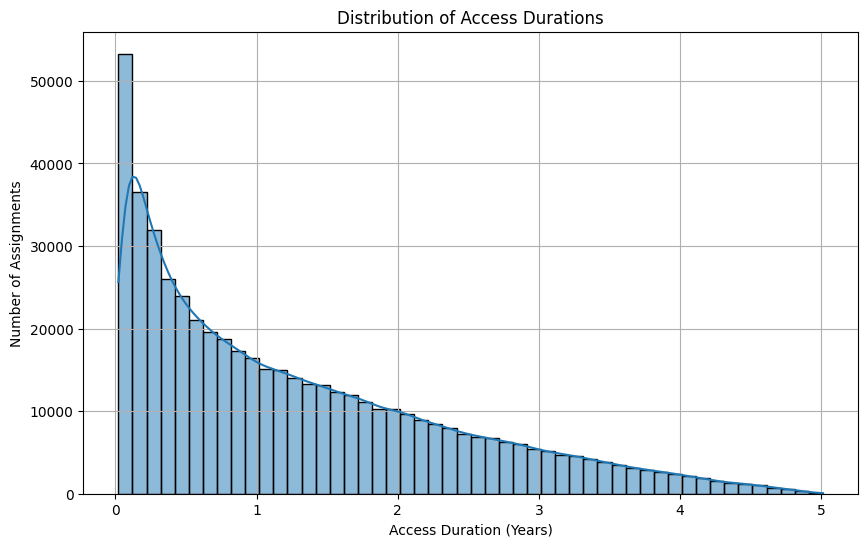

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(assignments_with_dates['access_duration_years'], bins=50, kde=True)
plt.title("Distribution of Access Durations")
plt.xlabel("Access Duration (Years)")
plt.ylabel("Number of Assignments")
plt.grid(True)
plt.show()


In [ ]:
df_dic['all_batches_combined_withName.csv']

,combination_id,entitlement_1,entitlement_2,entitlement_1_name,entitlement_2_name,frequency,log_frequency,is_rare,max_risk,min_risk,...,cluster,distance_to_center,is_anomaly,anomaly_score,best_k,anomaly_threshold,batch_id,batch_entitlements,batch_employees,processing_timestamp
0,ENT1278_ENT1292,ENT1278,ENT1292,Write_TreasuryManagementAmericasnotifications,Admin_TradingPlatformAsianotifications,6,1.945910,0,8,6,...,2,1.174612,False,0.320980,5,2.914811,1,20,10,2025-06-13 12:08:09.737987
1,ENT1278_ENT1311,ENT1278,ENT1311,Write_TreasuryManagementAmericasnotifications,Admin_TradingPlatformAsiadashboards,7,2.079442,0,8,6,...,2,1.597854,False,0.436638,5,2.914811,1,20,10,2025-06-13 12:08:09.737987
2,ENT1278_ENT1368,ENT1278,ENT1368,Write_TreasuryManagementAmericasnotifications,Admin_TradingPlatformAmericasconfigurationsett...,4,1.609438,0,8,6,...,2,1.695364,False,0.463284,5,2.914811,1,20,10,2025-06-13 12:08:09.737987
3,ENT1278_ENT1396,ENT1278,ENT1396,Write_TreasuryManagementAmericasnotifications,Read_TradingPlatformAmericasdashboards,7,2.079442,0,6,6,...,3,1.901619,False,0.519646,5,2.914811,1,20,10,2025-06-13 12:08:09.737987
4,ENT1278_ENT1476,ENT1278,ENT1476,Write_TreasuryManagementAmericasnotifications,Read_RiskEngineEuropeworkflowrules,7,2.079442,0,6,5,...,3,1.925825,False,0.526261,5,2.914811,1,20,10,2025-06-13 12:08:09.737987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18921,ENT682_ENT952,ENT682,ENT952,Admin_SharePointPortaluseraccounts,Admin_PaymentHubAsiabatchjobs,1,0.693147,1,8,6,...,2,2.550027,False,0.438520,5,3.508315,100,20,10,2025-06-13 12:08:51.105583
18922,ENT682_ENT968,ENT682,ENT968,Admin_SharePointPortaluseraccounts,Admin_PaymentHubEuropebatchjobs,2,1.098612,0,8,6,...,2,1.431247,False,0.246127,5,3.508315,100,20,10,2025-06-13 12:08:51.105583
18923,ENT868_ENT952,ENT868,ENT952,Admin_CoreBankingEuropeworkflowrules,Admin_PaymentHubAsiabatchjobs,2,1.098612,0,8,8,...,0,2.677710,False,0.460477,5,3.508315,100,20,10,2025-06-13 12:08:51.105583
18924,ENT868_ENT968,ENT868,ENT968,Admin_CoreBankingEuropeworkflowrules,Admin_PaymentHubEuropebatchjobs,4,1.609438,0,8,8,...,0,2.633203,False,0.452823,5,3.508315,100,20,10,2025-06-13 12:08:51.105583
